**Predicting Load and Price Based on Weather and Energy Data **








**Introduction**

In this project, we aim to predict the load and price of energy using weather and energy datasets. Accurate predictions can aid in optimizing energy distribution and planning. The datasets used are:

Weather Dataset: Contains various weather features such as temperature, humidity, wind speed, etc.
Energy Dataset: Contains details about energy generation from different sources and associated pricing information.





**Data Loading and Preprocessing**

First, we load the necessary libraries and datasets, followed by data preprocessing steps.


**Importing Necessary Libraries**

In [1]:
#Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense

**Loading the Datasets**

In [2]:
#Read datasets
df_weather = pd.read_csv('weather_features.csv',parse_dates=['dt_iso'])

df_energy = pd.read_csv('energy_dataset.csv',parse_dates=['time'])

**Data Preprocessing**

In [3]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead'],
                            axis=1)

In [4]:
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True)
df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'], utc=True)


In [5]:
# List of numerical columns to average
numerical_columns = ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']

# List of categorical columns to take the mode
categorical_columns = ['weather_id', 'weather_main', 'weather_description', 'weather_icon']

# Group by time and aggregate numerical columns by mean and categorical columns by mode
weather_aggregated = df_weather.groupby('dt_iso').agg({**{col: 'mean' for col in numerical_columns}, **{col: lambda x: x.mode()[0] for col in categorical_columns}}).reset_index()

In [6]:
weather_aggregated.to_csv('weather.csv', index=False)

In [7]:
# Convert time columns to datetime for merging
df_energy['time'] = pd.to_datetime(df_energy['time'])
weather_aggregated['time'] = pd.to_datetime(weather_aggregated['dt_iso'])
weather_aggregated = weather_aggregated.drop(columns=['dt_iso'])
# Merge the datasets on the time column
merged_data = pd.merge(df_energy, weather_aggregated, on='time', how='left')

merged_data.shape

(17617, 36)

In [8]:
merged_data.to_csv('merged.csv', index=False)

In [9]:
data = pd.read_csv('merged.csv')

**Exploratory Data Analysis (EDA)**

Conducting EDA helps in understanding the relationships and patterns within the data.

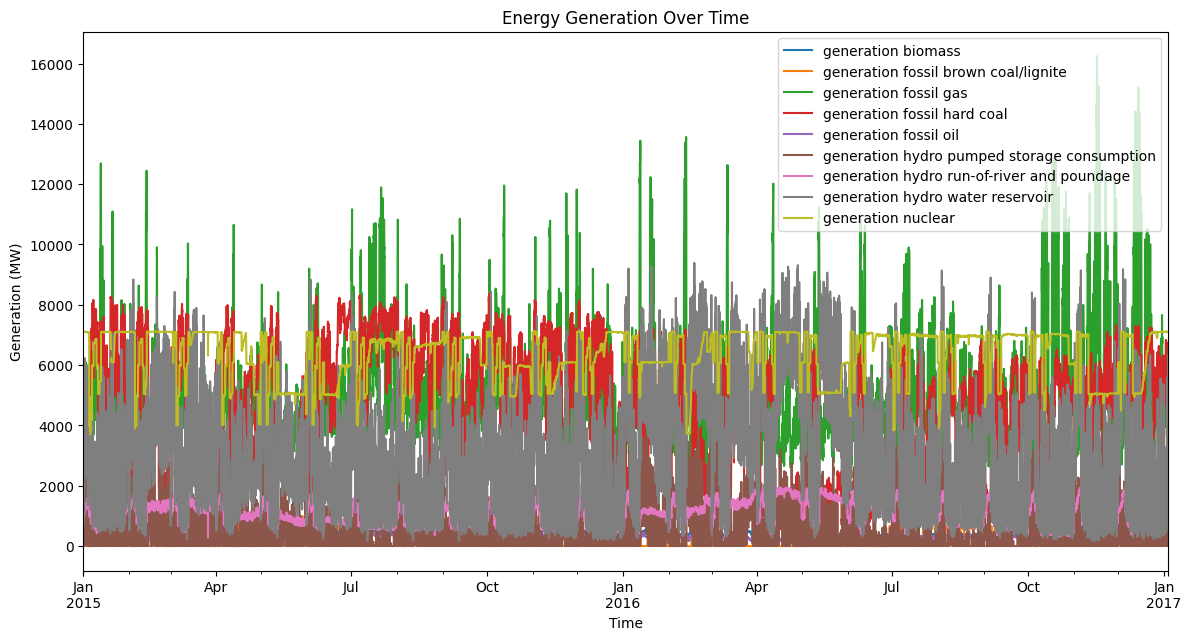

In [10]:
# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'])

# Set the 'time' column as the index
data.set_index('time', inplace=True)

# Plot the overall energy generation over time
plt.figure(figsize=(14, 7))
data[['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear']].plot(ax=plt.gca())
plt.title('Energy Generation Over Time')
plt.xlabel('Time')
plt.ylabel('Generation (MW)')
plt.legend(loc='upper right')
plt.show()

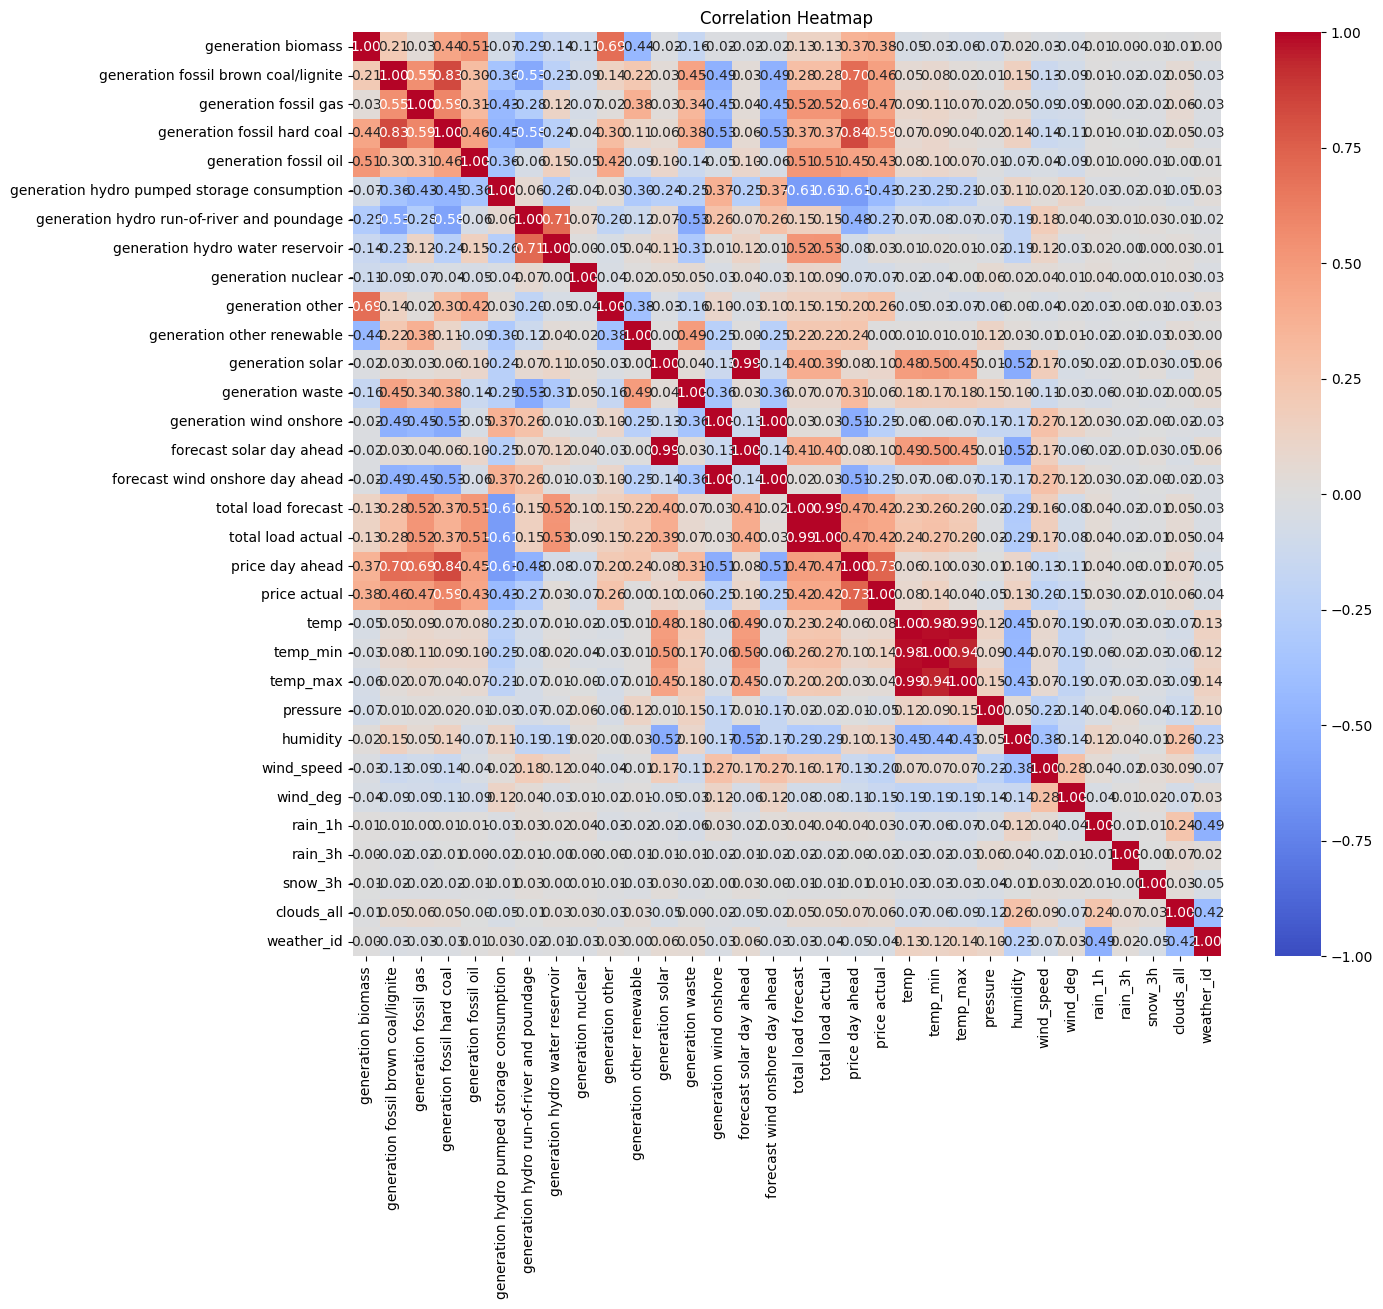

In [11]:
# Select only numeric columns for the correlation matrix
numeric_data = data.select_dtypes(include=[float, int])

# Correlation heatmap
plt.figure(figsize=(14, 12))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

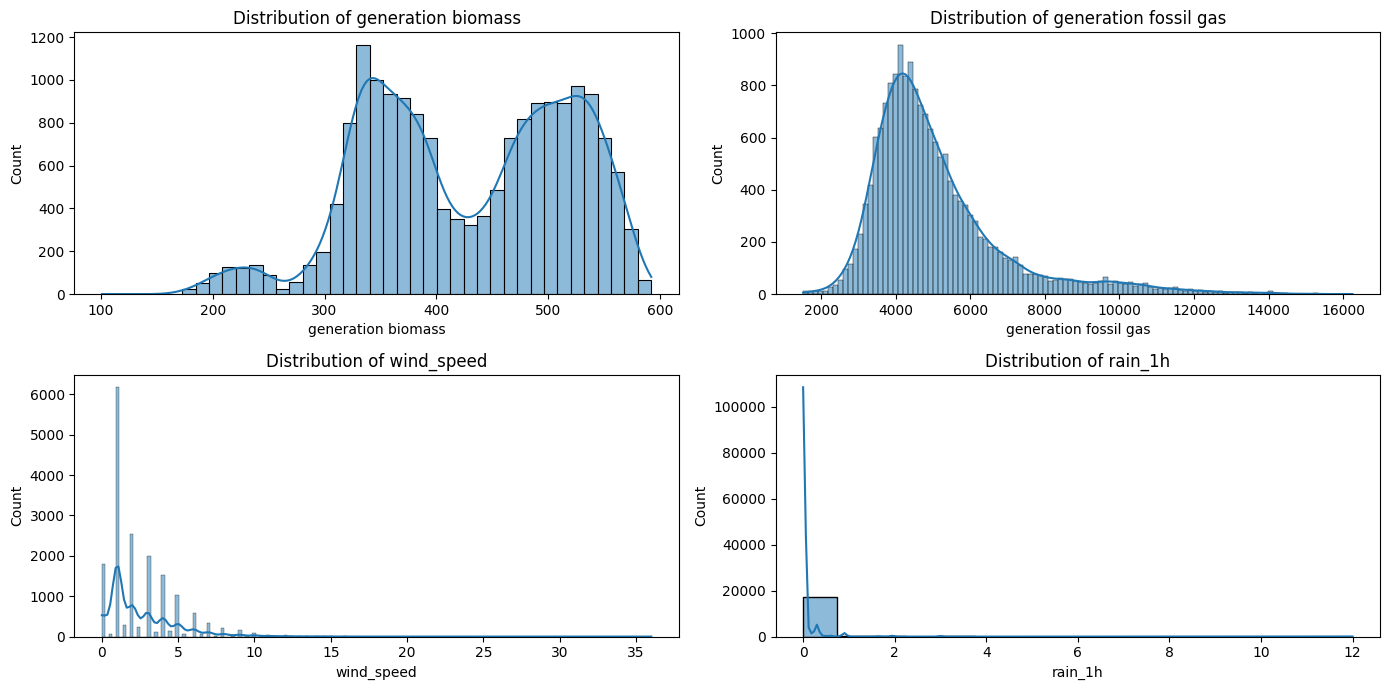

In [12]:
# Distribution plots
plt.figure(figsize=(14, 7))
for i, column in enumerate(['generation biomass', 'generation fossil gas', 'wind_speed', 'rain_1h'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[column].dropna(), kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

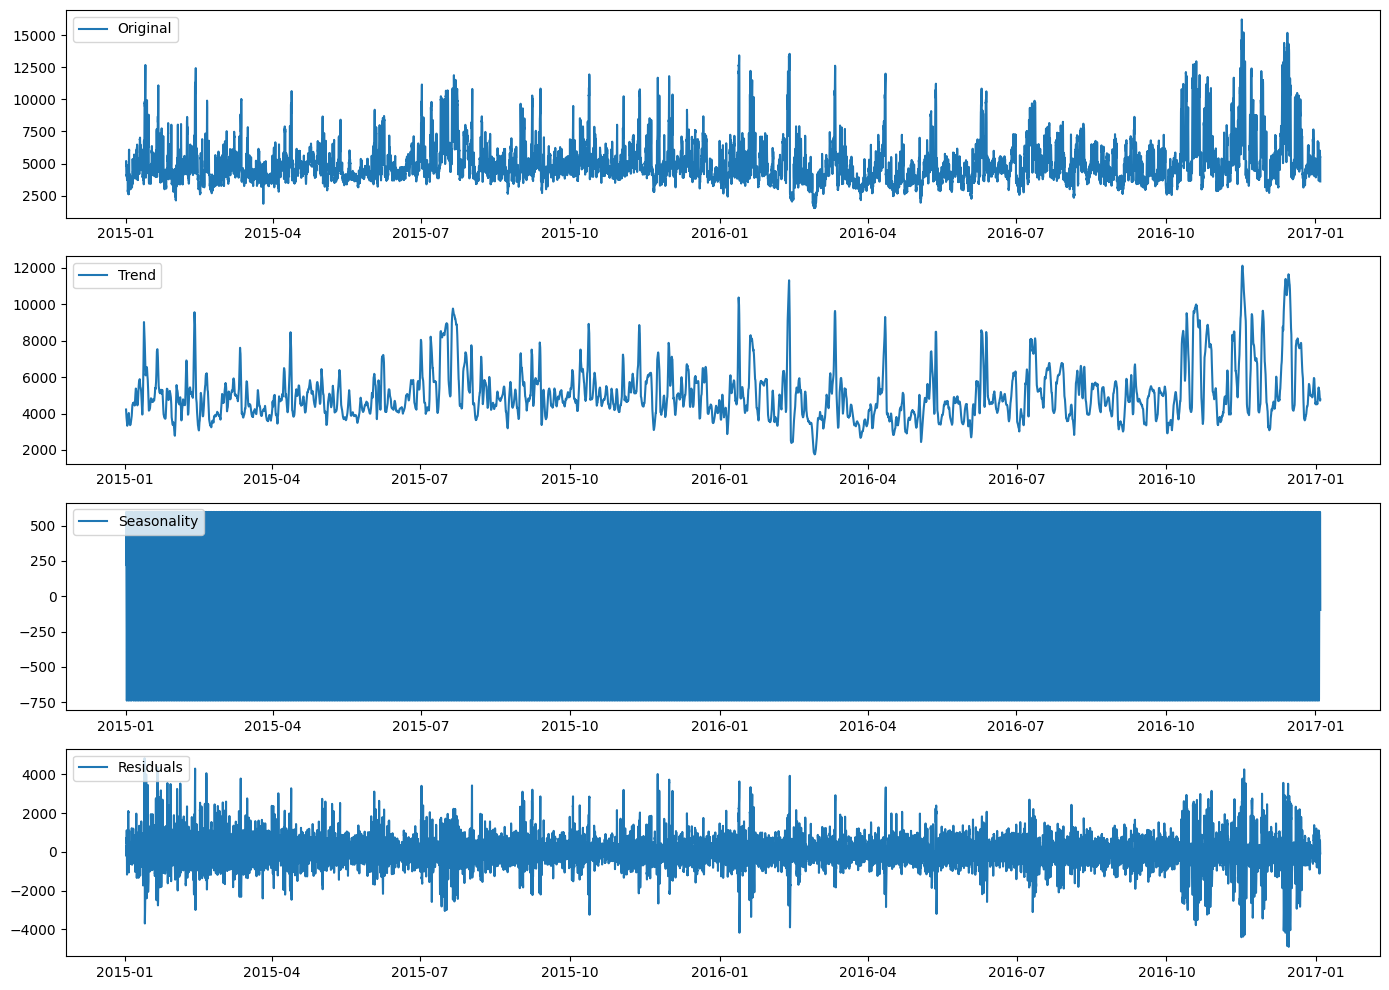

(-12.099952874741234,
 2.0291849290794698e-22,
 44,
 17555,
 {'1%': -3.4307225580434384,
  '5%': -2.8617046562981927,
  '10%': -2.5668576422678093},
 258507.17023690403)

In [13]:
# Select a column for analysis
column = 'generation fossil gas'
series = data[column].dropna()

# Decompose the time series
decomposition = seasonal_decompose(series, model='additive', period=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(series, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(series.dropna())
adf_result

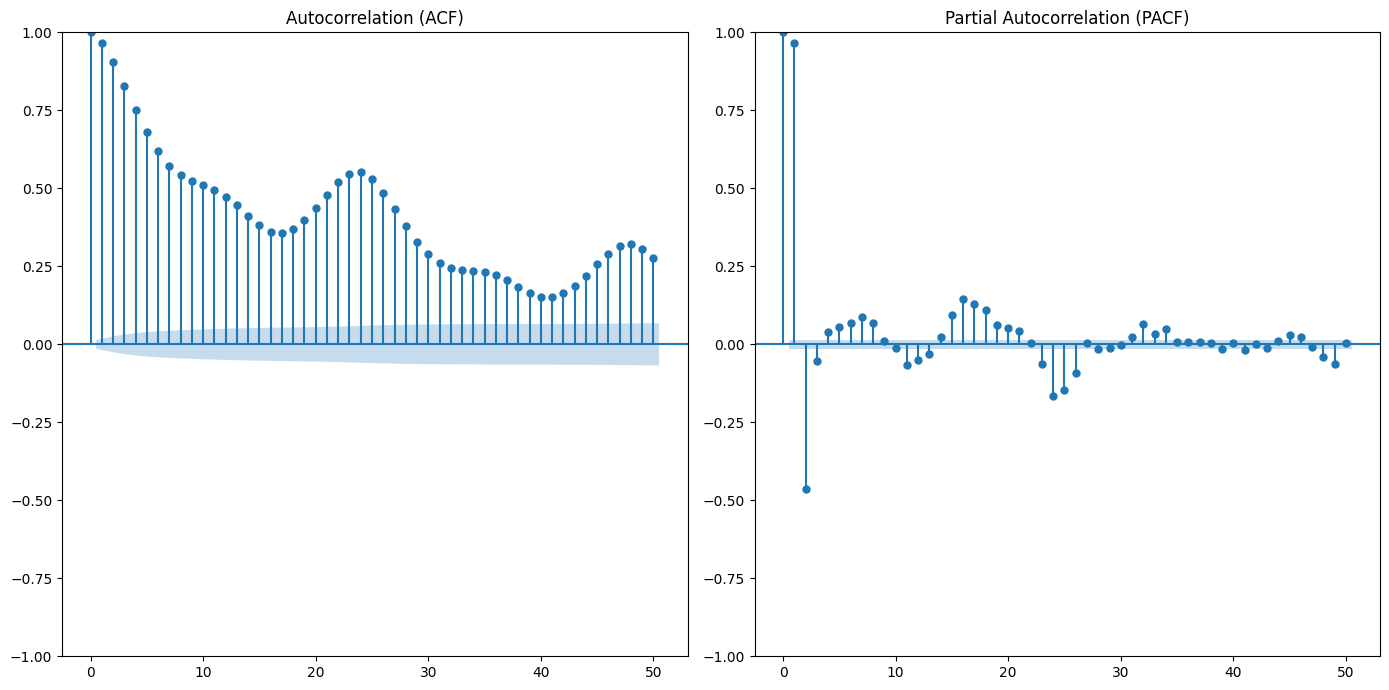

In [14]:
# Plot ACF and PACF
plt.figure(figsize=(14, 7))

plt.subplot(121)
plot_acf(series.dropna(), ax=plt.gca(), lags=50)
plt.title('Autocorrelation (ACF)')

plt.subplot(122)
plot_pacf(series.dropna(), ax=plt.gca(), lags=50)
plt.title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()


In [15]:
data = pd.read_csv('merged.csv')

**Feature engineering**

In [16]:
import pandas as pd

def find_peak_non_peak(df, datetime_col, demand_col, price_col, peak_threshold=0.8):

    df['datetime'] = pd.to_datetime(df[datetime_col])
    df['hour'] = df['datetime'].dt.hour
    df['date'] = df['datetime'].dt.date

    # Calculate daily maximum demand and apply threshold
    df['max_demand_daily'] = df.groupby('date')[demand_col].transform('max')
    df['peak_hour'] = df[demand_col] >= df['max_demand_daily'] * peak_threshold

    # Analyze price during peak hours (use the peak price where peak_hour is True)
    df['peak_price'] = df.apply(lambda row: row[price_col] if row['peak_hour'] else 0, axis=1)

    return df


data = find_peak_non_peak(data.copy(), 'time', 'total load actual', 'price actual')


<ipython-input-17-b981ba6a2e0c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['day_of_week_name'], y=data['day_of_week_demand'], palette='Set2')  # Set a categorical color palette


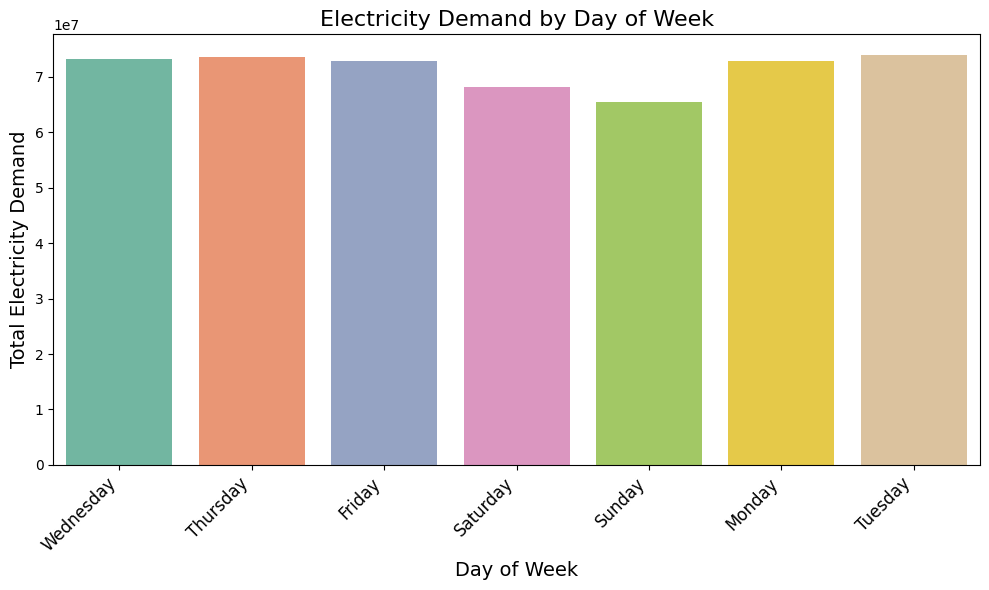

In [17]:
def add_day_of_week_demand(df, datetime_col, demand_col):
  df['day_of_week'] = pd.to_datetime(df[datetime_col]).dt.dayofweek
  day_of_week_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
  df['day_of_week_name'] = df['day_of_week'].apply(lambda x: day_of_week_names[x])
  daily_demand = df.groupby('day_of_week_name')[demand_col].sum()
  df['day_of_week_demand'] = df['day_of_week_name'].apply(lambda x: daily_demand.get(x))

  return df



data= add_day_of_week_demand(data.copy(), 'time', 'total load actual')


# Data Visualization (Day of Week Demand)


plt.figure(figsize=(10, 6))

# Create bar chart with clear labels
sns.barplot(x=data['day_of_week_name'], y=data['day_of_week_demand'], palette='Set2')  # Set a categorical color palette

# Customize x-axis labels for readability and prevent overlapping
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Total Electricity Demand', fontsize=14)
plt.title('Electricity Demand by Day of Week', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

In [18]:
def add_day_type_demand(df, datetime_col, demand_col):

    df['datetime'] = pd.to_datetime(df[datetime_col])
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekend' if x in [5, 6] else 'Weekday')

    # Calculate total daily demand for weekdays and weekends
    df['date'] = df['datetime'].dt.date
    daily_demand = df.groupby(['date', 'day_type'])[demand_col].sum().reset_index()
    daily_demand.rename(columns={demand_col: 'daily_demand'}, inplace=True)

    # Merge the daily demand back to the original dataframe
    df = pd.merge(df, daily_demand, on=['date', 'day_type'], how='left')

    return df


data = add_day_type_demand(data.copy(), 'time', 'total load actual')

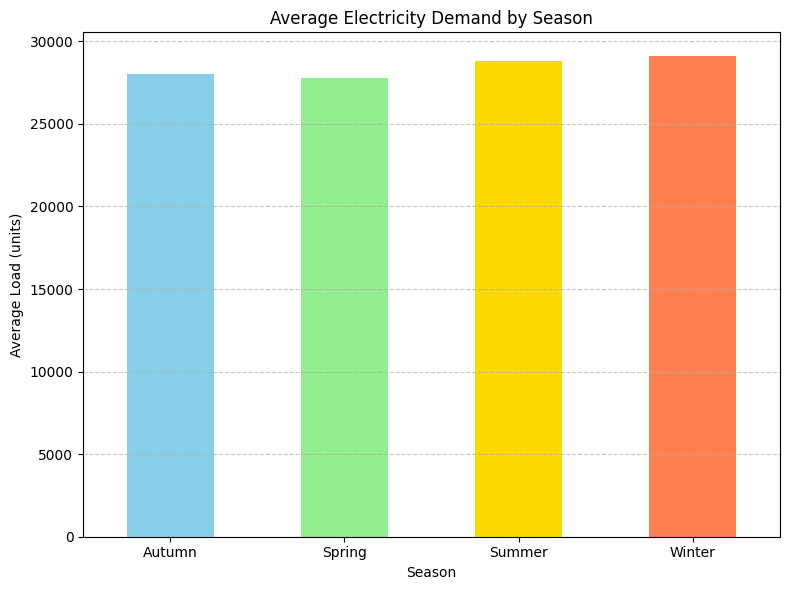

In [19]:
def create_seasons_column_spain(df, datetime_column_name):


    # Ensure the datetime column is in datetime format
    df[datetime_column_name] = pd.to_datetime(df[datetime_column_name])

    # Extract month as an integer (1-12)
    df['month'] = df[datetime_column_name].dt.month

    # Define season mapping
    season_mapping = {
        1: 'Winter',
        2: 'Winter',
        3: 'Spring',
        4: 'Spring',
        5: 'Spring',
        6: 'Summer',
        7: 'Summer',
        8: 'Summer',
        9: 'Autumn',
        10: 'Autumn',
        11: 'Autumn',
        12: 'Winter'
    }

    # Create the "seasons" column based on month and mapping
    df['seasons'] = df['month'].map(season_mapping)

    return df

# Apply the function to your DataFrame
data = create_seasons_column_spain(data.copy(), 'time')

# Group data by seasons (
seasonal_demand = data.groupby('seasons')['total load actual'].mean()

# Create a bar chart
plt.figure(figsize=(8, 6))
seasonal_demand.plot(kind='bar', color=['skyblue', 'lightgreen', 'gold', 'coral'])
plt.title('Average Electricity Demand by Season')
plt.xlabel('Season')
plt.ylabel('Average Load (units)')
plt.xticks(rotation=0)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better visualization
plt.tight_layout()
plt.show()


In [20]:
def add_monthly_demand_price(df, datetime_column_name, demand_column_name, price_column_name):


  # Extract month names as strings
  df['month_name'] = df[datetime_column_name].dt.month_name()

  # Calculate monthly average demand and price using loops or vectorized operations (consider efficiency for large datasets)
  for month in df['month_name'].unique():
    df[f'demand_{month}'] = df[df['month_name'] == month][demand_column_name].mean()
    df[f'price_{month}'] = df[df['month_name'] == month][price_column_name].mean()

  # Drop the temporary 'month_name' column (optional)
  # df.drop('month_name', axis=1, inplace=True)

  return df

# Apply the function to your DataFrame
data = add_monthly_demand_price(data.copy(), 'time', 'total load actual', 'price actual')

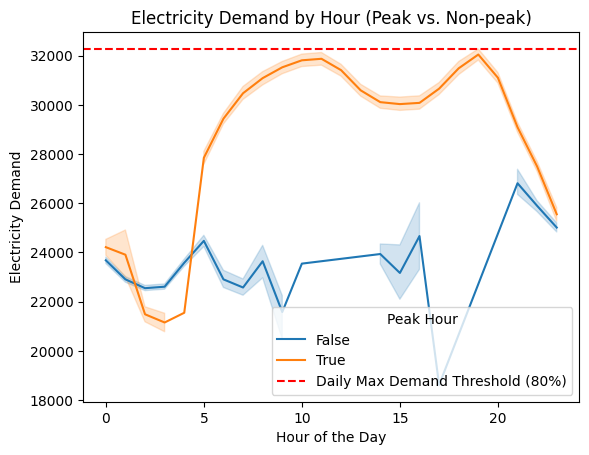

In [21]:
sns.lineplot(x='hour', y='total load actual', hue='peak_hour', data=data)
plt.axhline(y=data['max_demand_daily'].max() * 0.8, color='red', linestyle='--', label='Daily Max Demand Threshold (80%)')  # Adjust threshold as needed
plt.xlabel('Hour of the Day')
plt.ylabel('Electricity Demand')
plt.title('Electricity Demand by Hour (Peak vs. Non-peak)')
plt.legend(title='Peak Hour')
plt.show()

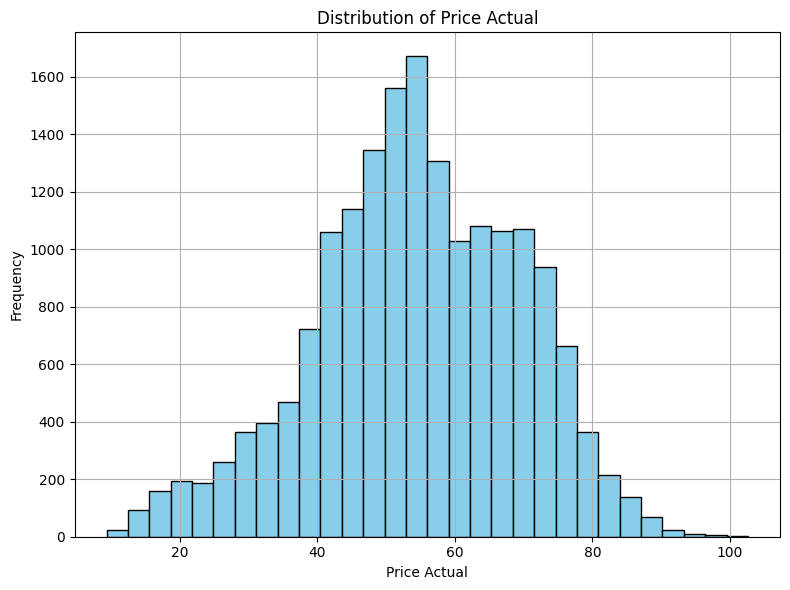

<ipython-input-22-1bba22376911>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='price actual', data=data, palette='Set2')


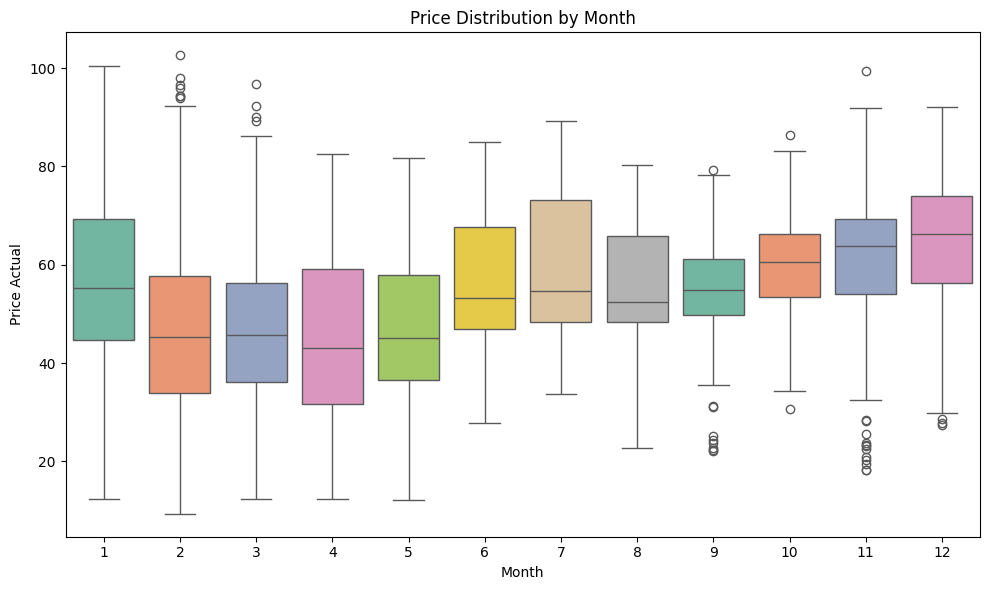

In [22]:
# Plotting histogram of price actual
plt.figure(figsize=(8, 6))
plt.hist(data['price actual'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Price Actual')
plt.xlabel('Price Actual')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()
# Box Plot for Price Distribution Across Different Categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='price actual', data=data, palette='Set2')
plt.title('Price Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Price Actual')
plt.tight_layout()
plt.show()

**Model Training**

We train models to predict energy load and price using the cleaned and processed data.

**Preparing the Data for Modeling**

In [23]:
data = pd.read_csv('merged.csv')
# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'])

# Extract additional time features
data['hour'] = data['time'].dt.hour
data['day_of_week'] = data['time'].dt.dayofweek
data['month'] = data['time'].dt.month

# Drop the original 'time' column
data.drop('time', axis=1, inplace=True)

# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

# One-hot encode the categorical columns
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_data = encoder.fit_transform(data[categorical_columns])

# Convert encoded data to DataFrame and add column names
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# Drop original categorical columns and concatenate encoded columns
data_numeric = data.drop(categorical_columns, axis=1)
data_numeric = pd.concat([data_numeric, encoded_df], axis=1)

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data_numeric), columns=data_numeric.columns)


# Check correlations with target variables
corr_price = data_imputed.corr()['price actual'].sort_values(ascending=False)
corr_load = data_imputed.corr()['total load actual'].sort_values(ascending=False)

# Select features that have high correlation with the target variables (absolute value > 0.1)
features_price = corr_price[abs(corr_price) > 0.1].index.tolist()
features_load = corr_load[abs(corr_load) > 0.1].index.tolist()

# Remove the target variable from the feature lists
features_price.remove('price actual')
features_load.remove('total load actual')

# Split data into features (X) and target (y)
X_price = data_imputed[features_price]
y_price = data_imputed['price actual']

X_load = data_imputed[features_load]
y_load = data_imputed['total load actual']

# Split data into training and testing sets
X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)
X_load_train, X_load_test, y_load_train, y_load_test = train_test_split(X_load, y_load, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_price_train_scaled = scaler.fit_transform(X_price_train)
X_price_test_scaled = scaler.transform(X_price_test)

X_load_train_scaled = scaler.fit_transform(X_load_train)
X_load_test_scaled = scaler.transform(X_load_test)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**Linear Regression**

In [24]:
# Train a linear regression model for price prediction
model_price = LinearRegression()
model_price.fit(X_price_train_scaled, y_price_train)

# Train a linear regression model for load prediction
model_load = LinearRegression()
model_load.fit(X_load_train_scaled, y_load_train)

# Make predictions on the test set
y_price_pred = model_price.predict(X_price_test_scaled)
y_load_pred = model_load.predict(X_load_test_scaled)

# Calculate MAPE for both predictions
mape_price = mean_absolute_percentage_error(y_price_test, y_price_pred)
mape_load = mean_absolute_percentage_error(y_load_test, y_load_pred)

mape_price, mape_load


(0.13597154700863365, 0.012223883753805958)

In [25]:
# Calculate R² for load prediction
r2_price = r2_score(y_price_test, y_price_pred)
r2_load = r2_score(y_load_test, y_load_pred)

r2_price, r2_load

(0.6721728698287244, 0.9822995496995297)

In [26]:
# Find the number of predictors (features) for each model
k_price = X_price_train_scaled.shape[1]
k_load = X_load_train_scaled.shape[1]

# Calculate adjusted R² using the formula
adj_r2_price = 1 - (1 - r2_price) * (len(y_price_test) - 1) / (len(y_price_test) - k_price - 1)
adj_r2_load = 1 - (1 - r2_load) * (len(y_load_test) - 1) / (len(y_load_test) - k_load - 1)

adj_r2_price, adj_r2_load

(0.6701128307359601, 0.982157743516865)

**Random Forest**

In [27]:
# Function to calculate adjusted R-squared
def adjusted_r2_score(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Train Random Forest for price and load prediction
rf_model_price = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_price.fit(X_price_train_scaled, y_price_train)
y_price_pred_rf = rf_model_price.predict(X_price_test_scaled)

mape_price_rf = mean_absolute_percentage_error(y_price_test, y_price_pred_rf)



rf_model_load = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_load.fit(X_load_train_scaled, y_load_train)
y_load_pred_rf = rf_model_load.predict(X_load_test_scaled)


mape_load_rf = mean_absolute_percentage_error(y_load_test, y_load_pred_rf)

mape_price_rf, mape_load_rf

(0.049694383528137494, 0.011469921912453827)

In [28]:
r2_price_rf = r2_score(y_price_test, y_price_pred_rf)
r2_load_rf = r2_score(y_load_test, y_load_pred_rf)
r2_price_rf,r2_load_rf

(0.933563246928242, 0.982892412229398)

In [29]:
adj_r2_price_rf = adjusted_r2_score(r2_price_rf, len(y_price_test), X_price_test_scaled.shape[1])
adj_r2_load_rf = adjusted_r2_score(r2_load_rf, len(y_load_test), X_load_test_scaled.shape[1])
adj_r2_price_rf,adj_r2_load_rf

(0.9331457637612672, 0.9827553557322373)

**Random Forest after Hyperparameter Tuning**

In [31]:
# Define parameter grids for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}
grid_search_rf_price = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
grid_search_rf_price.fit(X_price_train_scaled, y_price_train)

grid_search_rf_load = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
grid_search_rf_load.fit(X_load_train_scaled, y_load_train)

best_rf_price = grid_search_rf_price.best_estimator_
best_rf_load = grid_search_rf_load.best_estimator_

y_price_pred_best_rf = best_rf_price.predict(X_price_test_scaled)
y_load_pred_best_rf = best_rf_load.predict(X_load_test_scaled)

mape_price_best_rf = mean_absolute_percentage_error(y_price_test, y_price_pred_best_rf)
mape_load_best_rf = mean_absolute_percentage_error(y_load_test, y_load_pred_best_rf)

mape_price_best_rf,mape_load_best_rf

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


(0.049410825190854483, 0.011413699981568106)

In [32]:
r2_price_best_rf = r2_score(y_price_test, y_price_pred_best_rf)
r2_load_best_rf = r2_score(y_load_test, y_load_pred_best_rf)
r2_price_best_rf,r2_load_best_rf

(0.9336169773279801, 0.9831758332152121)

In [33]:
adj_r2_price_best_rf = adjusted_r2_score(r2_price_best_rf, len(y_price_test), X_price_test_scaled.shape[1])
adj_r2_load_best_rf = adjusted_r2_score(r2_load_best_rf, len(y_load_test), X_load_test_scaled.shape[1])
adj_r2_price_best_rf,adj_r2_load_best_rf

(0.9331998317984787, 0.9830410473296687)

**Gradient Boosting **

In [34]:
# Train Gradient Boosting models for Price and load prediction
gb_model_price = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model_price.fit(X_price_train_scaled, y_price_train)
y_price_pred_gb = gb_model_price.predict(X_price_test_scaled)
mape_price_gb = mean_absolute_percentage_error(y_price_test, y_price_pred_gb)

gb_model_load = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model_load.fit(X_load_train_scaled, y_load_train)
y_load_pred_gb = gb_model_load.predict(X_load_test_scaled)
mape_load_gb = mean_absolute_percentage_error(y_load_test, y_load_pred_gb)

mape_price_gb,mape_load_gb

(0.09184279082076999, 0.011753228807809197)

In [35]:
r2_price_gb = r2_score(y_price_test, y_price_pred_gb)
r2_load_gb = r2_score(y_load_test, y_load_pred_gb)
r2_price_gb,r2_load_gb

(0.8451617174831867, 0.9831935194785425)

In [36]:
adj_r2_price_gb = adjusted_r2_score(r2_price_gb, len(y_price_test), X_price_test_scaled.shape[1])
adj_r2_load_gb = adjusted_r2_score(r2_load_gb, len(y_load_test), X_load_test_scaled.shape[1])
adj_r2_price_gb,adj_r2_load_gb

(0.844188726276283, 0.9830588752855237)

**Gradient Boosting after Hyperparameter Tuning**

In [37]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
# Perform GridSearchCV for Gradient Boosting (Price)
grid_search_gb_price = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid_gb, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
grid_search_gb_price.fit(X_price_train_scaled, y_price_train)

# Perform GridSearchCV for Gradient Boosting (Load)
grid_search_gb_load = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid_gb, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
grid_search_gb_load.fit(X_load_train_scaled, y_load_train)

best_gb_price = grid_search_gb_price.best_estimator_
best_gb_load = grid_search_gb_load.best_estimator_

y_price_pred_best_gb = best_gb_price.predict(X_price_test_scaled)
y_load_pred_best_gb = best_gb_load.predict(X_load_test_scaled)

mape_price_best_gb = mean_absolute_percentage_error(y_price_test, y_price_pred_best_gb)
mape_load_best_gb = mean_absolute_percentage_error(y_load_test, y_load_pred_best_gb)

mape_price_best_gb,mape_load_best_gb

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits


(0.056758137737077066, 0.010373268474013935)

In [38]:
r2_price_best_gb = r2_score(y_price_test, y_price_pred_best_gb)
r2_load_best_gb = r2_score(y_load_test, y_load_pred_best_gb)
r2_price_best_gb,r2_load_best_gb

(0.9343509784596429, 0.9861721129643064)

In [39]:
adj_r2_price_best_gb = adjusted_r2_score(r2_price_best_gb, len(y_price_test), X_price_test_scaled.shape[1])
adj_r2_load_best_gb = adjusted_r2_score(r2_load_best_gb, len(y_load_test), X_load_test_scaled.shape[1])
adj_r2_price_best_gb,adj_r2_load_best_gb

(0.933938445333711, 0.9860613316089417)

LSTM

In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assume data_imputed, features_price, y_price, features_load, y_load are already defined as per your initial setup

# Preprocess data for price
X_price = data_imputed[features_price]
y_price = data_imputed['price actual']
X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)
scaler_price = StandardScaler()
X_price_train_scaled = scaler_price.fit_transform(X_price_train)
X_price_test_scaled = scaler_price.transform(X_price_test)
X_price_train_scaled = X_price_train_scaled.reshape((X_price_train_scaled.shape[0], 1, X_price_train_scaled.shape[1]))
X_price_test_scaled = X_price_test_scaled.reshape((X_price_test_scaled.shape[0], 1, X_price_test_scaled.shape[1]))

# Define and train LSTM model for price
model_price = Sequential()
model_price.add(LSTM(50, activation='relu', input_shape=(1, X_price_train_scaled.shape[2])))
model_price.add(Dense(1))
model_price.compile(optimizer='adam', loss='mean_squared_error')
model_price.fit(X_price_train_scaled, y_price_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
y_price_pred_lstm = model_price.predict(X_price_test_scaled)
mape_price_lstm = mean_absolute_percentage_error(y_price_test, y_price_pred_lstm)
print(f"MAPE for LSTM (price): {mape_price_lstm}")

# Preprocess data for load
X_load = data_imputed[features_load]
y_load = data_imputed['total load actual']
X_load_train, X_load_test, y_load_train, y_load_test = train_test_split(X_load, y_load, test_size=0.2, random_state=42)
scaler_load = StandardScaler()
X_load_train_scaled = scaler_load.fit_transform(X_load_train)
X_load_test_scaled = scaler_load.transform(X_load_test)
X_load_train_scaled = X_load_train_scaled.reshape((X_load_train_scaled.shape[0], 1, X_load_train_scaled.shape[1]))
X_load_test_scaled = X_load_test_scaled.reshape((X_load_test_scaled.shape[0], 1, X_load_test_scaled.shape[1]))

# Define and train LSTM model for load
model_load = Sequential()
model_load.add(LSTM(50, activation='relu', input_shape=(1, X_load_train_scaled.shape[2])))
model_load.add(Dense(1))
model_load.compile(optimizer='adam', loss='mean_squared_error')
model_load.fit(X_load_train_scaled, y_load_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
y_load_pred_lstm = model_load.predict(X_load_test_scaled)
mape_load_lstm = mean_absolute_percentage_error(y_load_test, y_load_pred_lstm)

Epoch 1/100
353/353 [==============================] - 3s 5ms/step - loss: 2320.2236 - val_loss: 986.0811
Epoch 2/100
353/353 [==============================] - 1s 4ms/step - loss: 559.9391 - val_loss: 325.9533
Epoch 3/100
353/353 [==============================] - 1s 4ms/step - loss: 244.3191 - val_loss: 185.7690
Epoch 4/100
353/353 [==============================] - 1s 4ms/step - loss: 158.6783 - val_loss: 129.7710
Epoch 5/100
353/353 [==============================] - 2s 4ms/step - loss: 116.7734 - val_loss: 97.9206
Epoch 6/100
353/353 [==============================] - 3s 8ms/step - loss: 91.5832 - val_loss: 79.3314
Epoch 7/100
353/353 [==============================] - 2s 6ms/step - loss: 76.3807 - val_loss: 67.7338
Epoch 8/100
353/353 [==============================] - 3s 7ms/step - loss: 66.4883 - val_loss: 59.9141
Epoch 9/100
353/353 [==============================] - 2s 6ms/step - loss: 59.8688 - val_loss: 55.4683
Epoch 10/100
353/353 [==============================] - 2s 6ms/

In [41]:
mape_price_lstm,mape_load_lstm

(0.06777596789022092, 0.03709366557297629)

In [42]:
r2_price_lstm = r2_score(y_price_test, y_price_pred)
r2_load_lstm = r2_score(y_load_test, y_load_pred)
r2_price_lstm,r2_load_lstm

(0.6721728698287244, 0.9822995496995297)

In [43]:
adj_r2_price_lstm = adjusted_r2_score(r2_price_lstm, len(y_price_test), X_price_test_scaled.shape[1])
adj_r2_load_lstm = adjusted_r2_score(r2_load_lstm, len(y_load_test), X_load_test_scaled.shape[1])
adj_r2_price_lstm,adj_r2_load_lstm

(0.6720797900075514, 0.9822945240180134)

**ERROR METRICS COMPARISONS TO SELECT BEST MODEL **

ERROR METRICS CONSIDERED:

1.**Mean Absolute Percentage Error (MAPE)**

Significance: Measures the average magnitude of errors as a percentage of actual values. High/Low: Lower values indicate better model performance. Higher values indicate larger errors relative to actual values.

2.**R-squared (R²)**

Significance: Represents the proportion of the variance in the dependent variable that is predictable from the independent variables. High/Low: Values closer to 1 indicate better model performance, meaning the model explains a high proportion of variance. Values closer to 0 indicate poor model performance.

3.**Mean Absolute Error (MAE)**

Significance: Measures the average magnitude of errors in a set of predictions, without considering their direction. High/Low: Lower values indicate better model performance. Higher values indicate larger errors on average.

4.**Root Mean Squared Error (RMSE)**

Significance: Measures the square root of the average squared errors, providing a measure of the magnitude of prediction errors. High/Low: Lower values indicate better model performance. Higher values indicate larger prediction errors.


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE for Linear Regression
mae_price_lr = mean_absolute_error(y_price_test, y_price_pred)
rmse_price_lr = mean_squared_error(y_price_test, y_price_pred, squared=False)

mae_load_lr = mean_absolute_error(y_load_test, y_load_pred)
rmse_load_lr = mean_squared_error(y_load_test, y_load_pred, squared=False)

# Calculate MAE and RMSE for Random Forest
mae_price_rf = mean_absolute_error(y_price_test, y_price_pred_rf)
rmse_price_rf = mean_squared_error(y_price_test, y_price_pred_rf, squared=False)

mae_load_rf = mean_absolute_error(y_load_test, y_load_pred_rf)
rmse_load_rf = mean_squared_error(y_load_test, y_load_pred_rf, squared=False)

# Calculate MAE and RMSE for Best Random Forest
mae_price_best_rf = mean_absolute_error(y_price_test, y_price_pred_best_rf)
rmse_price_best_rf = mean_squared_error(y_price_test, y_price_pred_best_rf, squared=False)

mae_load_best_rf = mean_absolute_error(y_load_test, y_load_pred_best_rf)
rmse_load_best_rf = mean_squared_error(y_load_test, y_load_pred_best_rf, squared=False)

# Calculate MAE and RMSE for Gradient Boosting
mae_price_gb = mean_absolute_error(y_price_test, y_price_pred_gb)
rmse_price_gb = mean_squared_error(y_price_test, y_price_pred_gb, squared=False)

mae_load_gb = mean_absolute_error(y_load_test, y_load_pred_gb)
rmse_load_gb = mean_squared_error(y_load_test, y_load_pred_gb, squared=False)

# Calculate MAE and RMSE for Best Gradient Boosting
mae_price_best_gb = mean_absolute_error(y_price_test, y_price_pred_best_gb)
rmse_price_best_gb = mean_squared_error(y_price_test, y_price_pred_best_gb, squared=False)

mae_load_best_gb = mean_absolute_error(y_load_test, y_load_pred_best_gb)
rmse_load_best_gb = mean_squared_error(y_load_test, y_load_pred_best_gb, squared=False)

# Calculate MAE and RMSE for LSTM
mae_price_lstm = mean_absolute_error(y_price_test, y_price_pred_lstm)
rmse_price_lstm = mean_squared_error(y_price_test, y_price_pred_lstm, squared=False)

mae_load_lstm = mean_absolute_error(y_load_test, y_load_pred_lstm)
rmse_load_lstm = mean_squared_error(y_load_test, y_load_pred_lstm, squared=False)

**Conclusion**

This project aimed to predict energy load and price using historical weather and energy data. We performed data preprocessing, exploratory data analysis (EDA), and trained multiple machine learning models to achieve these goals. The datasets included:

**Weather Dataset:** Provided various weather features such as temperature, humidity, and wind speed.

**Energy Dataset:** Included details about energy generation, total load, and price.


**Model Performance and Selection **

In [45]:

import pandas as pd
from IPython.display import display, HTML

# Data for the price comparison table
price_data = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Best Random Forest', 'Gradient Boosting', 'Gradient Boosting(tuned)', 'LSTM'],
    'MAE (Price)': [mae_price_lr, mae_price_rf, mae_price_best_rf, mae_price_gb, mae_price_best_gb, mae_price_lstm],
    'RMSE (Price)': [rmse_price_lr, rmse_price_rf, rmse_price_best_rf, rmse_price_gb, rmse_price_best_gb, rmse_price_lstm],
    'MAPE (Price)': [mape_price, mape_price_rf, mape_price_best_rf, mape_price_gb, mape_price_best_gb, mape_price_lstm],
    'R2 (Price)': [r2_price, r2_price_rf, r2_price_best_rf, r2_price_gb, r2_price_best_gb, r2_price_lstm],
    'Adjusted R2 (Price)': [adj_r2_price, adj_r2_price_rf, adj_r2_price_best_rf, adj_r2_price_gb, adj_r2_price_best_gb, adj_r2_price_lstm]
})




# Save the DataFrame to an Excel file
price_data.to_excel('price_model_comparison.xlsx', index=False)

# Display the DataFrame
print('Price Model Comparison Table:')
display(HTML(price_data.to_html(index=False)))

load_data = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Best Random Forest', 'Gradient Boosting', 'Gradient Boosting(tuned)', 'LSTM'],
    'MAE (Load)': [mae_load_lr, mae_load_rf, mae_load_best_rf, mae_load_gb, mae_load_best_gb, mae_load_lstm],
    'RMSE (Load)': [rmse_load_lr, rmse_load_rf, rmse_load_best_rf, rmse_load_gb, rmse_load_best_gb, rmse_load_lstm],
    'MAPE (Load)': [mape_load, mape_load_rf, mape_load_best_rf, mape_load_gb, mape_load_best_gb, mape_load_lstm],
    'R2 (Load)': [r2_load, r2_load_rf, r2_load_best_rf, r2_load_gb, r2_load_best_gb, r2_load_lstm],
    'Adjusted R2 (Load)': [adj_r2_load, adj_r2_load_rf, adj_r2_load_best_rf, adj_r2_load_gb, adj_r2_load_best_gb, adj_r2_load_lstm]
})



# Save the DataFrame to an Excel file
load_data.to_excel('load_model_comparison.xlsx', index=False)

# Display the DataFrame
print('Load Model Comparison Table:')
display(HTML(load_data.to_html(index=False)))




Price Model Comparison Table:


Model,MAE (Price),RMSE (Price),MAPE (Price),R2 (Price),Adjusted R2 (Price)
Linear Regression,6.228028,8.569992,0.135972,0.672173,0.670113
Random Forest,2.301634,3.858000,0.049694,0.933563,0.933146
Best Random Forest,2.285905,3.856439,0.049411,0.933617,0.933200
Gradient Boosting,4.172893,5.889754,0.091843,0.845162,0.844189
Gradient Boosting(tuned),2.650069,3.835060,0.056758,0.934351,0.933938
LSTM,3.195070,4.454291,0.067776,0.672173,0.672080


Load Model Comparison Table:


Model,MAE (Load),RMSE (Load),MAPE (Load),R2 (Load),Adjusted R2 (Load)
Linear Regression,343.993309,601.053801,0.012224,0.982300,0.982158
Random Forest,322.724878,590.902162,0.011470,0.982892,0.982755
Best Random Forest,321.177498,585.986989,0.011414,0.983176,0.983041
Gradient Boosting,330.887182,585.678901,0.011753,0.983194,0.983059
Gradient Boosting(tuned),290.174782,531.250195,0.010373,0.986172,0.986061
LSTM,1010.332804,1527.837353,0.037094,0.982300,0.982295


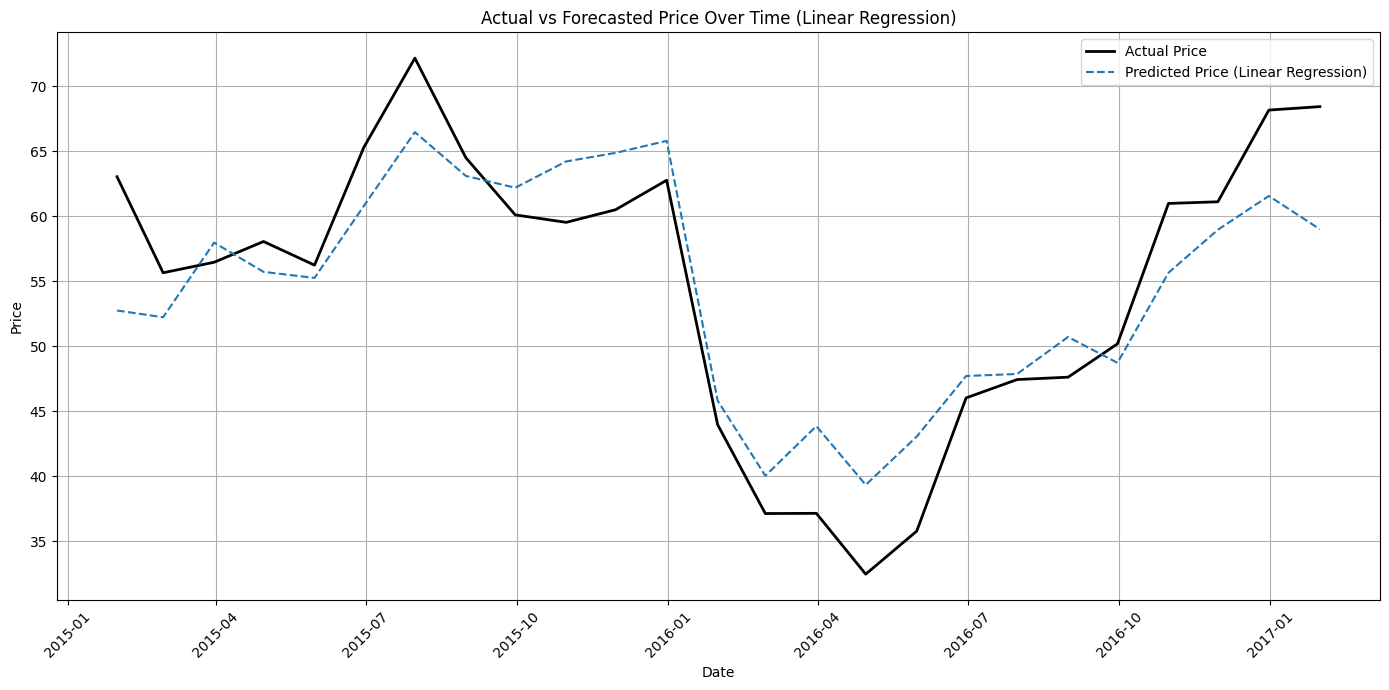

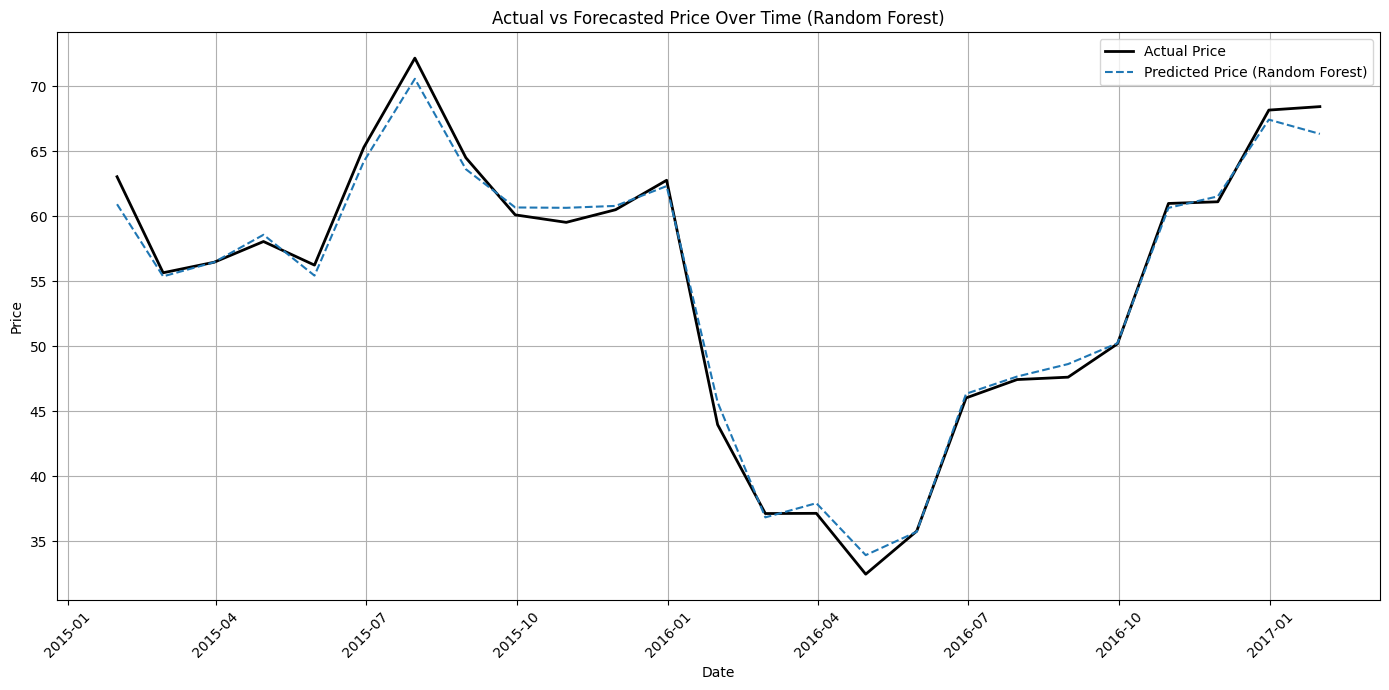

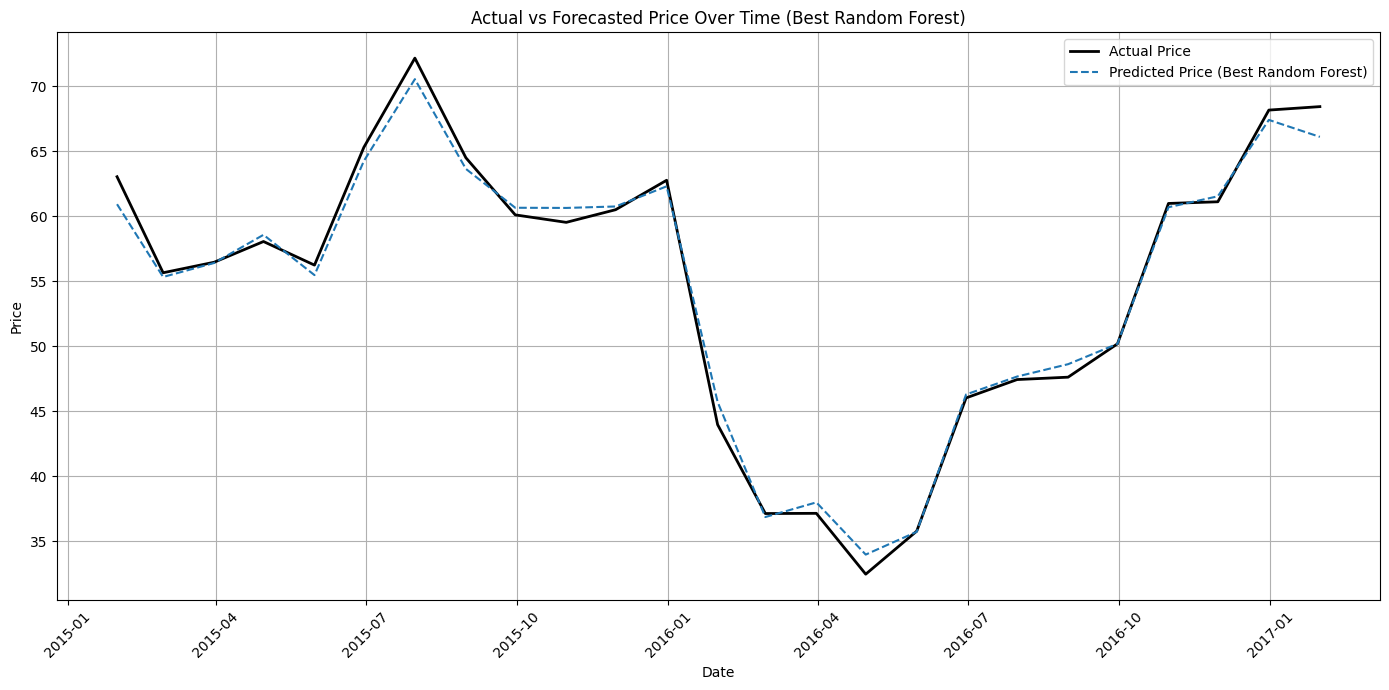

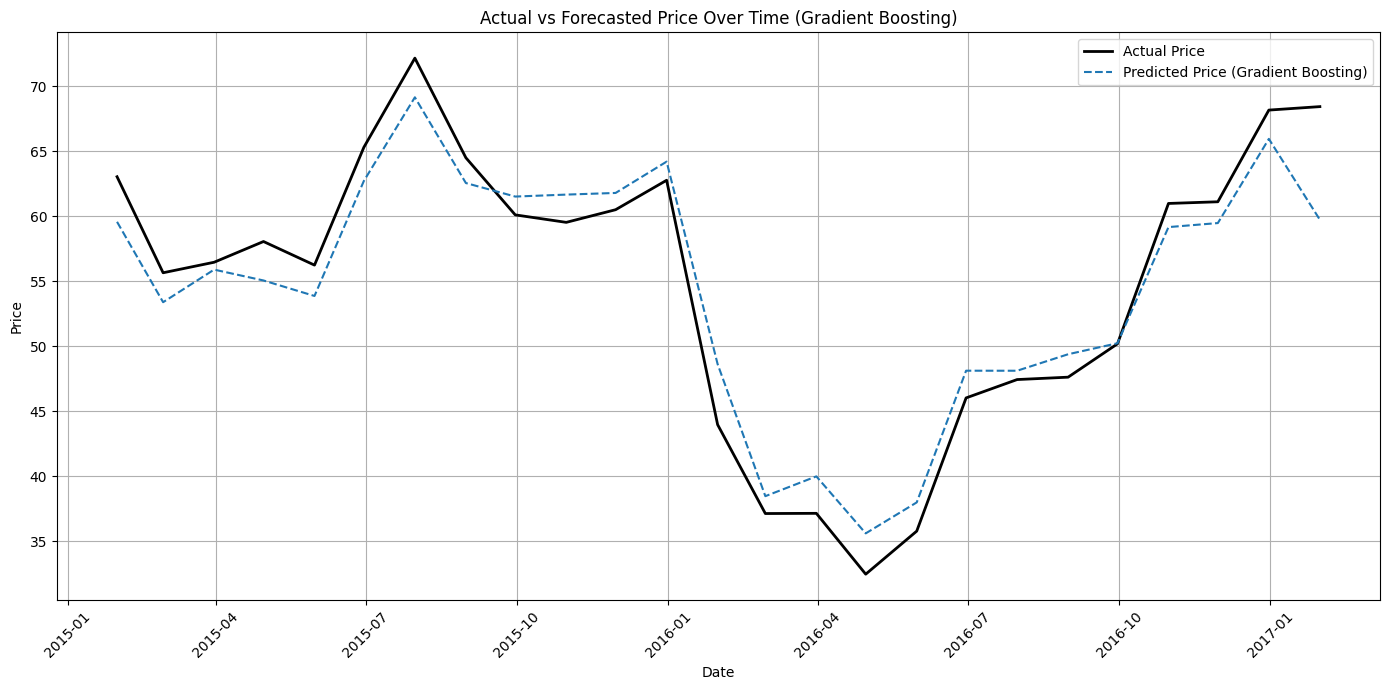

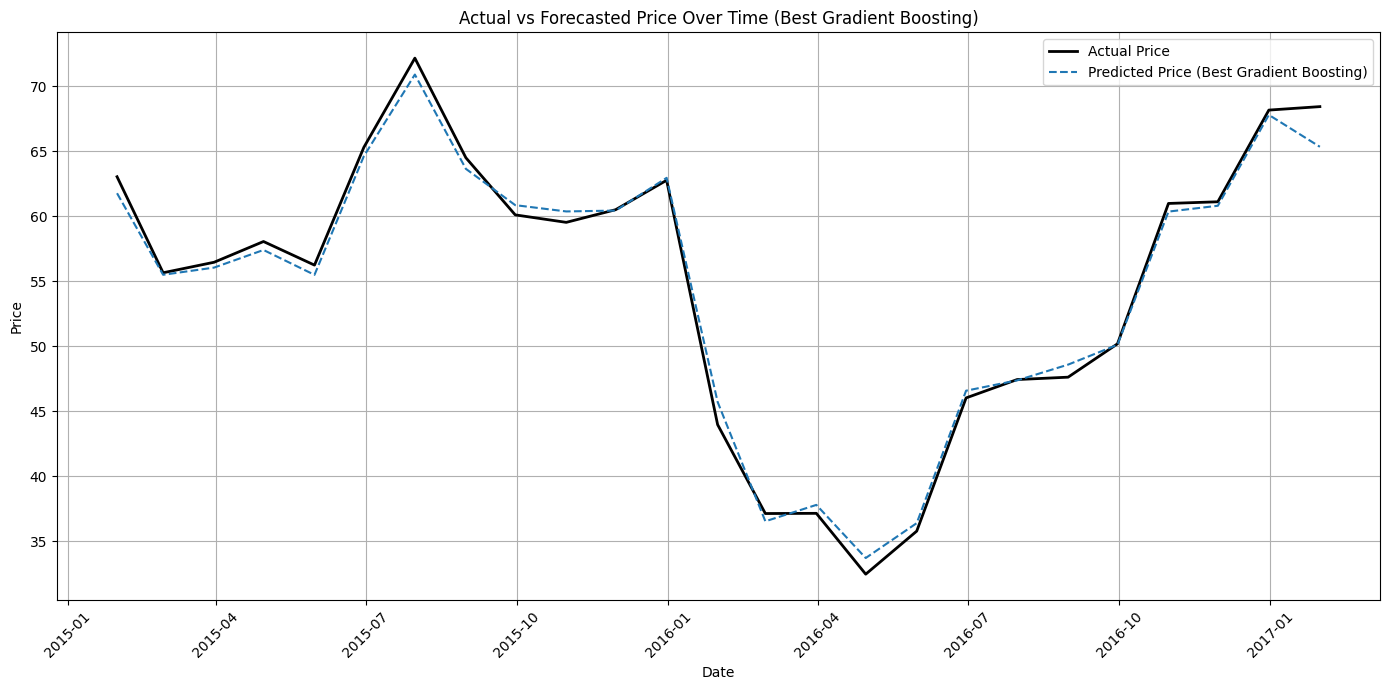

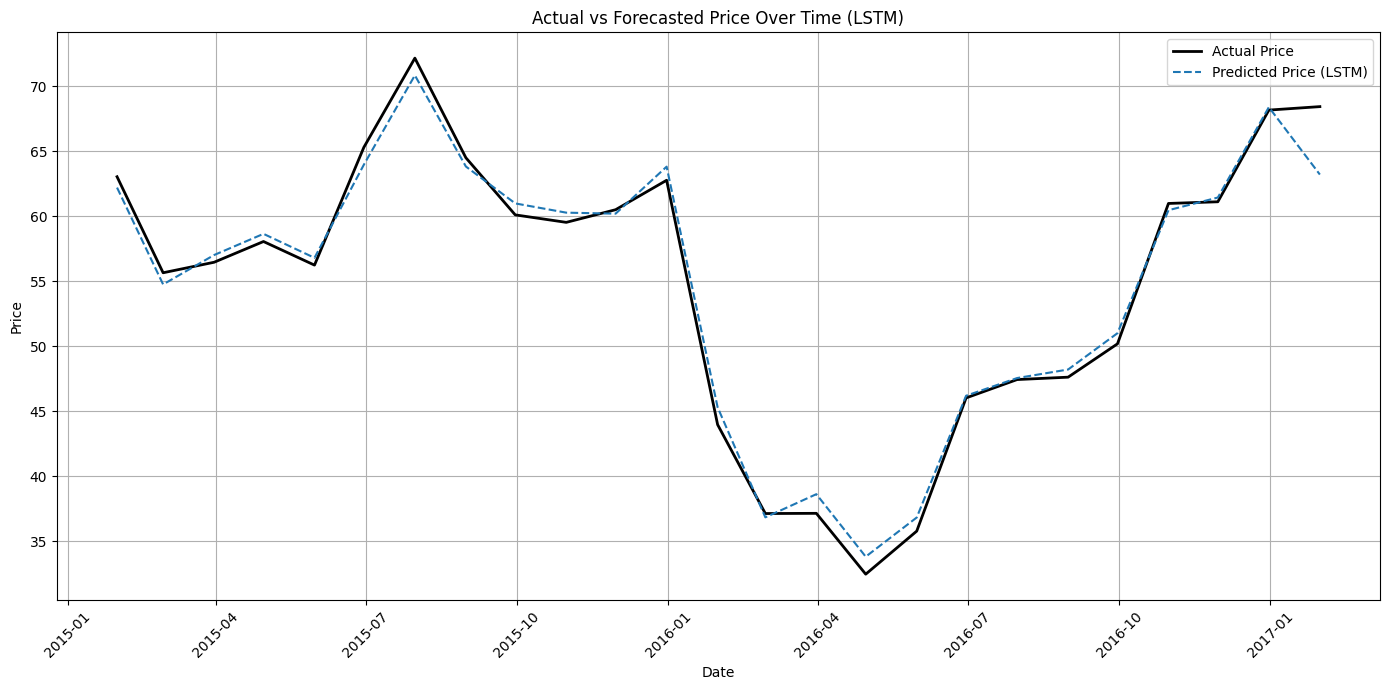

In [46]:
import matplotlib.pyplot as plt
data = pd.read_csv('merged.csv')


# Create a DataFrame to hold the actual and predicted prices for the test set
price_results_df = pd.DataFrame({
    'dt_iso': merged_data['time'].iloc[y_price_test.index],  # Use the correct indices for dates
    'price_actual': y_price_test,
    'Linear Regression': y_price_pred.flatten(),
    'Random Forest': y_price_pred_rf.flatten(),
    'Best Random Forest': y_price_pred_best_rf.flatten(),
    'Gradient Boosting': y_price_pred_gb.flatten(),
    'Best Gradient Boosting': y_price_pred_best_gb.flatten(),
    'LSTM': y_price_pred_lstm.flatten()
})
price_results_df.set_index('dt_iso', inplace=True)

# Resample the data to monthly frequency and calculate the mean
price_results_monthly = price_results_df.resample('M').mean()

# Define model names for iteration
model_names = ['Linear Regression', 'Random Forest', 'Best Random Forest', 'Gradient Boosting', 'Best Gradient Boosting', 'LSTM']

# Plotting for each model
for model in model_names:
    plt.figure(figsize=(14, 7))

    # Plot actual values
    plt.plot(price_results_monthly.index, price_results_monthly['price_actual'], label='Actual Price', color='black', linestyle='-', linewidth=2)

    # Plot predicted values
    plt.plot(price_results_monthly.index, price_results_monthly[model], label=f'Predicted Price ({model})', linestyle='--')

    # Formatting the plot
    plt.title(f'Actual vs Forecasted Price Over Time ({model})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Display the plot
    plt.show()




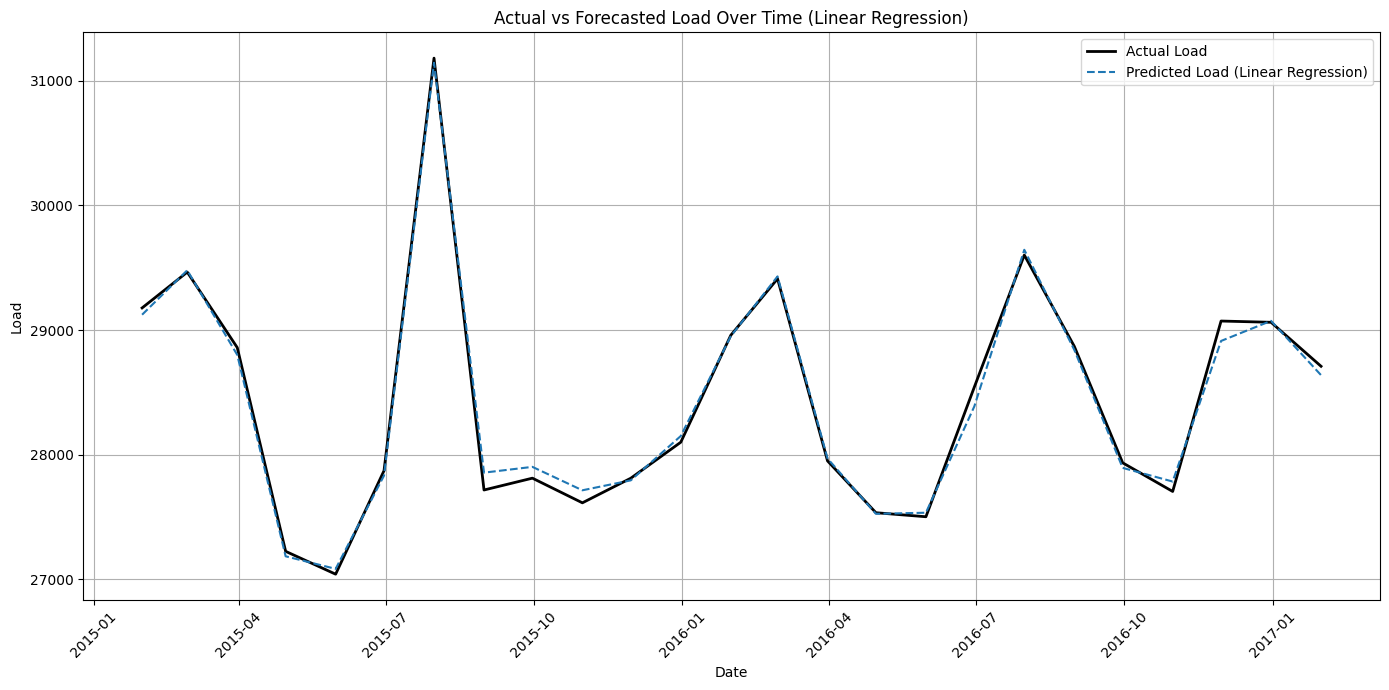

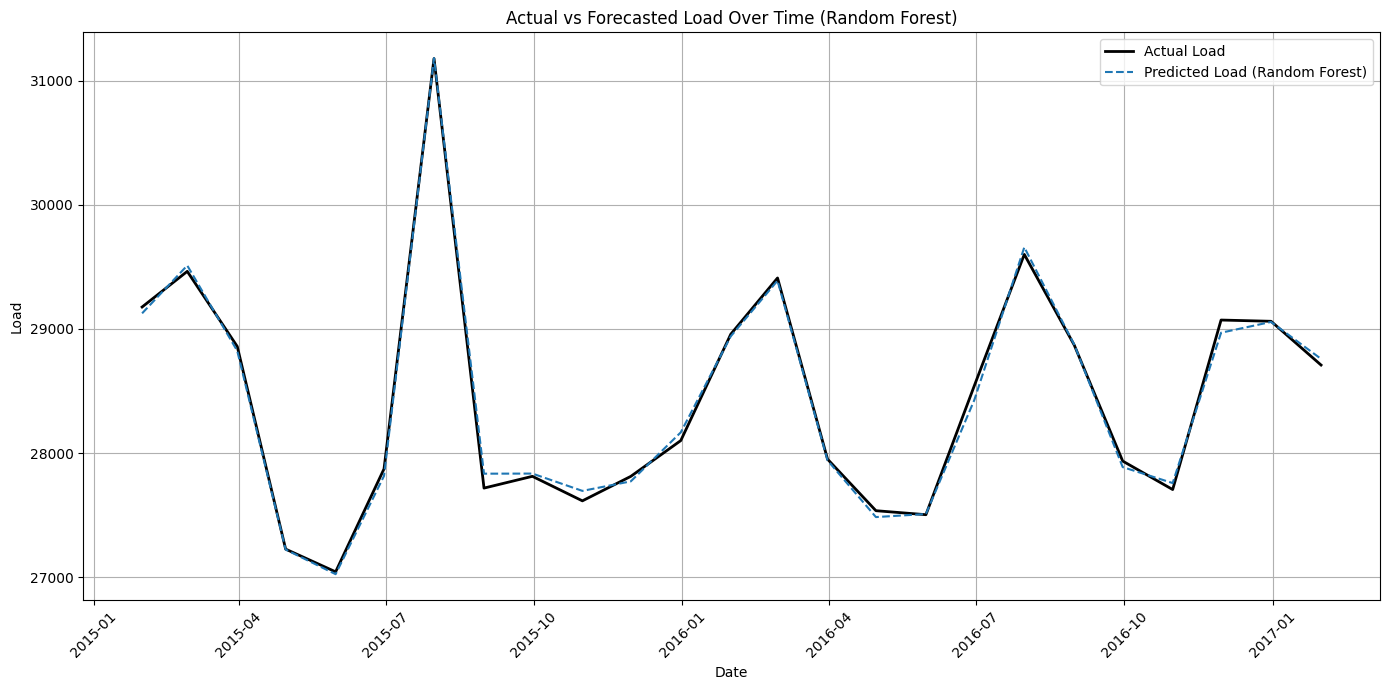

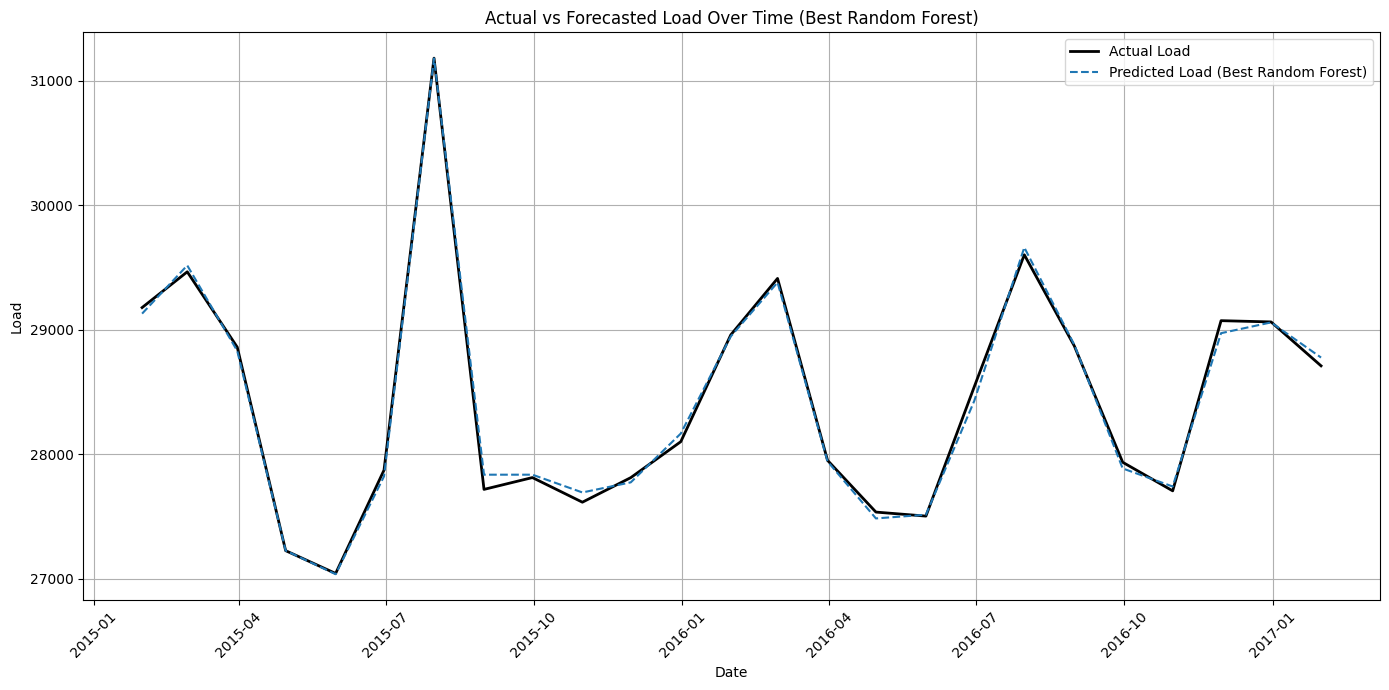

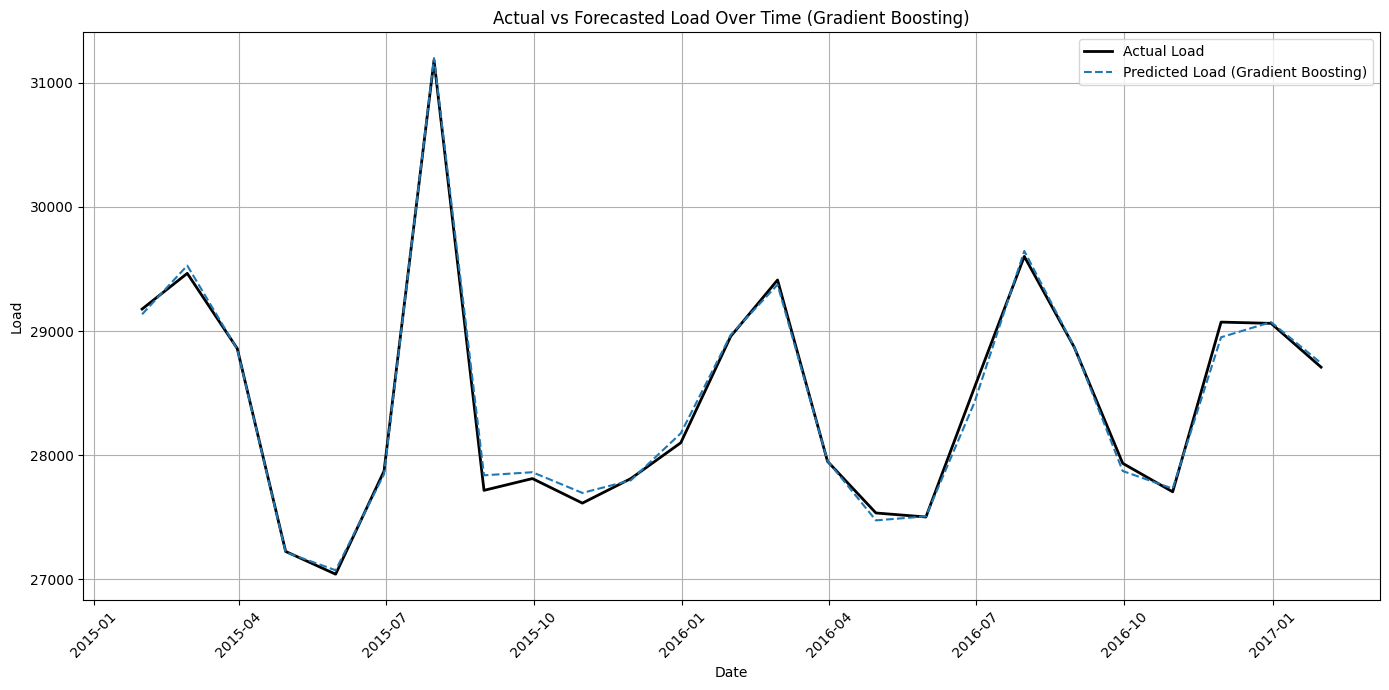

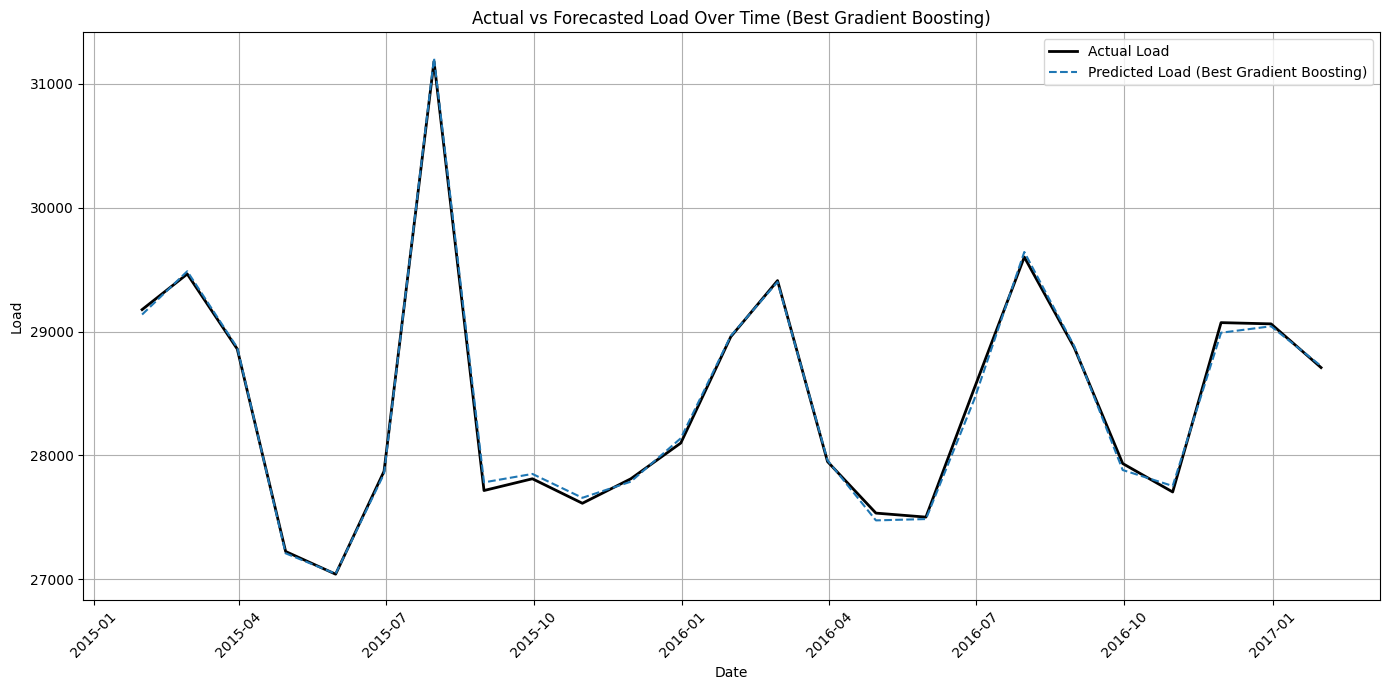

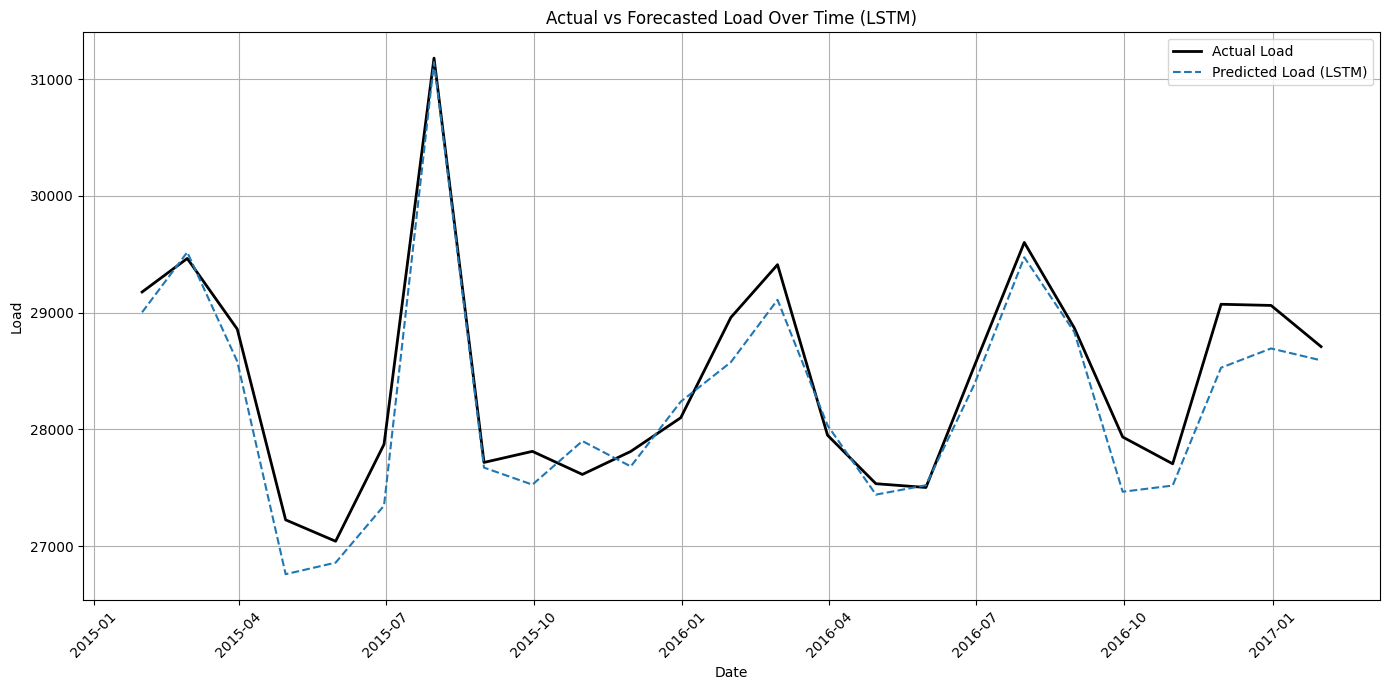

In [47]:
# Create a DataFrame to hold the actual and predicted loads for the test set
load_results_df = pd.DataFrame({
    'dt_iso': merged_data['time'].iloc[y_load_test.index],  # Use the correct indices for dates
    'load_actual': y_load_test,
    'Linear Regression': y_load_pred.flatten(),
    'Random Forest': y_load_pred_rf.flatten(),
    'Best Random Forest': y_load_pred_best_rf.flatten(),
    'Gradient Boosting': y_load_pred_gb.flatten(),
    'Best Gradient Boosting': y_load_pred_best_gb.flatten(),
    'LSTM': y_load_pred_lstm.flatten()
})
load_results_df.set_index('dt_iso', inplace=True)

# Resample the data to monthly frequency and calculate the mean
load_results_monthly = load_results_df.resample('M').mean()

# Define model names for iteration
model_names = ['Linear Regression', 'Random Forest', 'Best Random Forest', 'Gradient Boosting', 'Best Gradient Boosting', 'LSTM']

# Plotting for each model
for model in model_names:
    plt.figure(figsize=(14, 7))

    # Plot actual values
    plt.plot(load_results_monthly.index, load_results_monthly['load_actual'], label='Actual Load', color='black', linestyle='-', linewidth=2)

    # Plot predicted values
    plt.plot(load_results_monthly.index, load_results_monthly[model], label=f'Predicted Load ({model})', linestyle='--')

    # Formatting the plot
    plt.title(f'Actual vs Forecasted Load Over Time ({model})')
    plt.xlabel('Date')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Display the plot
    plt.show()


**Predicting Energy Load**

For predicting the energy load (total load actual), we experimented with various models including Linear Regression,LSTM, Random Forest Regressor, and Gradient Boosting Regressor. Here are the key points:

**Gradient Boosting Regressor:** This model showed superior performance in terms of R2 score, capturing non-linear relationships between weather features and energy load effectively.

The Gradient Boosting Regressor was chosen as the best model for predicting energy load due to its ability to handle complex interactions between features and its robustness to overfitting with appropriate* hyperparameter tuning*.





**Predicting Energy Price**

For predicting the energy price (price actual), we tested models including Linear Regression, Random Forest Regressor, and Gradient Boosting Regressor. The notable findings are:

**Random Forest Regressor :** This model with appropriate* hyperparameter tuning* outperformed others by providing better R2 scores and capturing the trend in price variations accurately.

The Random Forest Regressor was selected as the best model for predicting energy price due to its strong performance in handling the non-linear and seasonal trends in the data. Additionally, it showed good generalization on the test set, indicating its robustness.